In [1]:

#     Final Project ML Part 1: COVID19 Forecasting
#     Authors:
#     Amitabh Rajkumar Saini, amitabhr@usc.edu
#     Shilpa Jain, shilpaj@usc.edu
#     Sushumna Khandelwal, sushumna@usc.edu


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import itertools
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,r2_score
import statsmodels.api as sm
from statsmodels.tsa.api import Holt,SimpleExpSmoothing,ExponentialSmoothing
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.dates as mdates
%matplotlib inline 
# !pip install mpld3
# import mpld3
# mpld3.enable_notebook()
from scipy.integrate import odeint
!pip install lmfit
import lmfit
from lmfit.lineshapes import gaussian, lorentzian
import warnings
warnings.filterwarnings('ignore')
from fbprophet import Prophet



Importing plotly failed. Interactive plots will not work.


In [2]:
covid_data = pd.read_csv("./Covid_Data/covid_19_data.csv")

In [3]:
covid_data.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [4]:
covid_data.shape

(19607, 8)

In [5]:
covid_data.isna().sum()

SNo                    0
ObservationDate        0
Province/State     10001
Country/Region         0
Last Update            0
Confirmed              0
Deaths                 0
Recovered              0
dtype: int64

In [6]:
covid_data["ObservationDate"]=pd.to_datetime(covid_data["ObservationDate"])
covid_data["Last Update"]=pd.to_datetime(covid_data["Last Update"])

covid_data_us=covid_data[covid_data["Country/Region"]=="US"]

In [7]:
covid_data_us.shape

(3772, 8)

In [8]:
covid_data_us.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
31,32,2020-01-22,Washington,US,2020-01-22 17:00:00,1.0,0.0,0.0
69,70,2020-01-23,Washington,US,2020-01-23 17:00:00,1.0,0.0,0.0
117,118,2020-01-24,Washington,US,2020-01-24 17:00:00,1.0,0.0,0.0
118,119,2020-01-24,Chicago,US,2020-01-24 17:00:00,1.0,0.0,0.0
158,159,2020-01-25,Washington,US,2020-01-25 17:00:00,1.0,0.0,0.0


In [9]:
covid_us_recovery_data = covid_data_us[(covid_data_us["Province/State"] == "Recovered")]

In [10]:
covid_us_recovery_data = covid_us_recovery_data[["ObservationDate","Recovered"]]

In [11]:
previous_dates = covid_data_us.ObservationDate.unique()[:62]
recovered_cases = np.zeros(len(previous_dates))

In [12]:
covid_us_recovery_data = pd.DataFrame(list(zip(previous_dates, recovered_cases)), columns=["ObservationDate","Recovered"]).append(covid_us_recovery_data)

In [13]:
covid_us_recovery_data.tail()

,ObservationDate,Recovered
18291,2020-04-24,99079.0
18610,2020-04-25,100372.0
18929,2020-04-26,106988.0
19250,2020-04-27,111424.0
19571,2020-04-28,115936.0


In [14]:
covid_data_us = covid_data_us[~(covid_data_us["Province/State"] == "Recovered")]

In [15]:
covid_data_us[covid_data_us["ObservationDate"]=="04/28/2020"].Confirmed.sum()

1012582.0

In [16]:
covid_data_us.isna().sum()

SNo                0
ObservationDate    0
Province/State     0
Country/Region     0
Last Update        0
Confirmed          0
Deaths             0
Recovered          0
dtype: int64

In [17]:
print("Size/Shape of the dataset: ",covid_data_us.shape)
print("Checking for null values:\n",covid_data_us.isnull().sum())
print("Checking Data-type of each column:\n",covid_data_us.dtypes)


Size/Shape of the dataset:  (3736, 8)
Checking for null values:
 SNo                0
ObservationDate    0
Province/State     0
Country/Region     0
Last Update        0
Confirmed          0
Deaths             0
Recovered          0
dtype: int64
Checking Data-type of each column:
 SNo                         int64
ObservationDate    datetime64[ns]
Province/State             object
Country/Region             object
Last Update        datetime64[ns]
Confirmed                 float64
Deaths                    float64
Recovered                 float64
dtype: object


### A. Data Analysis on Covid Data of United States

#### Covid Data Date Wise

In [18]:
datewise=covid_data_us.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Deaths":'sum'})
# datewise["Recovered"] = covid_us_recovery_data["Recovered"]


In [19]:
datewise = datewise.merge(covid_us_recovery_data, left_on=datewise.index, right_on="ObservationDate", how="left")

In [20]:
#covid_us_recovery_data.shape
datewise.shape

(98, 4)

In [21]:
datewise.head()

,Confirmed,Deaths,ObservationDate,Recovered
0,1.0,0.0,2020-01-22,0.0
1,1.0,0.0,2020-01-23,0.0
2,2.0,0.0,2020-01-24,0.0
3,2.0,0.0,2020-01-25,0.0
4,5.0,0.0,2020-01-26,0.0


In [22]:
covid_us_recovery_data.Recovered.tail()

18291     99079.0
18610    100372.0
18929    106988.0
19250    111424.0
19571    115936.0
Name: Recovered, dtype: float64

In [23]:
datewise["Active"]=datewise["Confirmed"] - datewise["Recovered"] - datewise["Deaths"]

In [24]:
datewise.tail()

,Confirmed,Deaths,ObservationDate,Recovered,Active
93,905333.0,51949.0,2020-04-24,99079.0,754305.0
94,938154.0,53755.0,2020-04-25,100372.0,784027.0
95,965783.0,54881.0,2020-04-26,106988.0,803914.0
96,988197.0,56259.0,2020-04-27,111424.0,820514.0
97,1012582.0,58355.0,2020-04-28,115936.0,838291.0


#### Covid Data StateWise

In [25]:
statewise = covid_data_us.groupby(["Province/State"]).agg({"Confirmed":"sum","Deaths":"sum","Recovered":"sum"})
statewise["TotalCases"]=statewise["Confirmed"] + statewise["Recovered"] + statewise["Deaths"]


In [26]:
statewise_sorted = statewise.sort_values(by="TotalCases",ascending=False)

In [27]:
statewise_sorted = statewise_sorted[~(statewise_sorted.index == "Recovered")]

In [28]:
statewise_sorted[:10]

,Confirmed,Deaths,Recovered,TotalCases
Province/State,,,,
New York,6130927.0,360516.0,0.0,6491443.0
New Jersey,2044007.0,90413.0,2.0,2134422.0
Massachusetts,887944.0,35656.0,8.0,923608.0
California,808044.0,26840.0,40.0,834924.0
Michigan,774889.0,52651.0,0.0,827540.0
Pennsylvania,751403.0,25171.0,0.0,776574.0
Illinois,729341.0,28132.0,16.0,757489.0
Florida,635017.0,17352.0,0.0,652369.0
Louisiana,598189.0,30196.0,0.0,628385.0


Text(0.5, 1.0, 'Top 15 States as per Number of Death Cases')

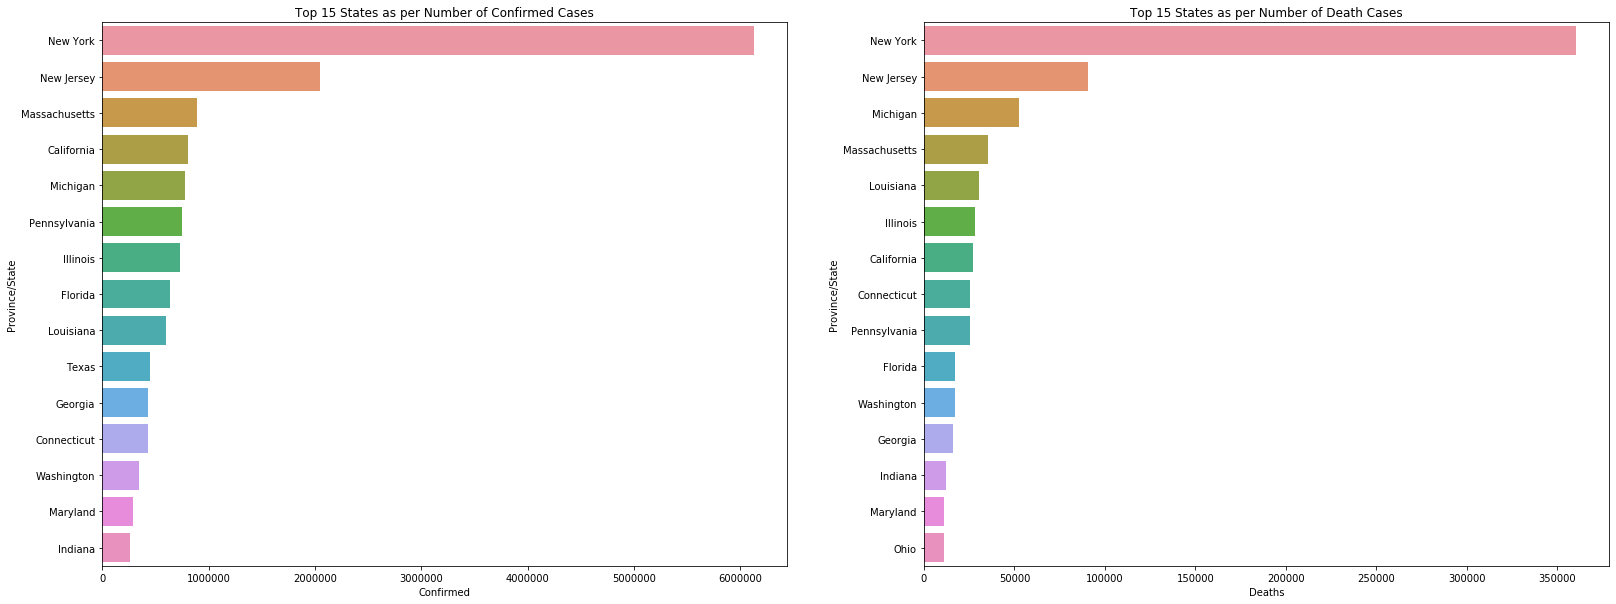

In [29]:
# statewise_sorted[["Confirmed"]][:10].plot(kind='pie', subplots=True, figsize=(8,8))
# statewise_sorted[["Recovered"]][:10].plot(kind='pie', subplots=True, figsize=(8,8))
# statewise_sorted[["Deaths"]][:10].plot(kind='pie', subplots=True, figsize=(8,8))

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(27,10))
top_15_confirmed=statewise_sorted.sort_values(["Confirmed"],ascending=False).head(15)
top_15_deaths=statewise_sorted.sort_values(["Deaths"],ascending=False).head(15)
sns.barplot(x=top_15_confirmed["Confirmed"],y=top_15_confirmed.index,ax=ax1)
ax1.set_title("Top 15 States as per Number of Confirmed Cases")
sns.barplot(x=top_15_deaths["Deaths"],y=top_15_deaths.index,ax=ax2)
ax2.set_title("Top 15 States as per Number of Death Cases")

In [30]:
# import matplotlib.pyplot as plt
 
# # Data to plot
# labels = statewise.index[:10]
# sizes = list(statewise.TotalCases[:10])
# # labels_type = ["Confirmed",'Deaths','Recovered']
# # sizes_type = [315,189,125,212,270,145,190,90]
# # colors = ['#ff6666', '#ffcc99', '#99ff99', '#66b3ff']
# # colors_gender = ['#c2c2f0','#ffb3e6', '#99ff99']*len(statewise.index)
# explode = [0.2]*len(statewise.index[:10]) 
# # explode_gender = (0.1,0.1,0.1)*len(statewise.index)
# #Plot
# plt.pie(sizes, labels=labels, startangle=90,frame=True, explode=explode,radius=3)
# # plt.pie(sizes_gender,colors=colors_gender,startangle=90, explode=explode_gender,radius=2 )
# #Draw circle
# centre_circle = plt.Circle((0,0),1.5,color='black', fc='white',linewidth=0)
# fig = plt.gcf()
# fig.gca().add_artist(centre_circle)
 
# plt.axis('equal')
# plt.tight_layout()
# plt.show()

#### Key Insights

In [31]:
print("Totol number of States with Disease Spread: ",len(covid_data_us["Province/State"].unique()))
print("Total number of Confirmed Cases: ",datewise["Confirmed"].iloc[-1])
print("Total number of Recovered Cases: ",datewise["Recovered"].iloc[-1])
print("Total number of Deaths Cases: ",datewise["Deaths"].iloc[-1])
print("Total number of Active Cases: ",datewise["Active"].iloc[-1])
print("Total number of Closed Cases: ",datewise["Recovered"].iloc[-1]+datewise["Deaths"].iloc[-1])
print("Approximate number of Confirmed Cases per Day: ",np.round(datewise["Confirmed"].iloc[-1]/datewise.shape[0]))
print("Approximate number of Recovered Cases per Day: ",np.round(datewise["Recovered"].iloc[-1]/datewise.shape[0]))
print("Approximate number of Death Cases per Day: ",np.round(datewise["Deaths"].iloc[-1]/datewise.shape[0]))
print("Approximate number of Confirmed Cases per hour around: ",np.round(datewise["Confirmed"].iloc[-1]/((datewise.shape[0])*24)))
print("Approximate number of Recovered Cases per hour around: ",np.round(datewise["Recovered"].iloc[-1]/((datewise.shape[0])*24)))
print("Approximate number of Death Cases per hour around the World: ",np.round(datewise["Deaths"].iloc[-1]/((datewise.shape[0])*24)))
print("Number of Confirmed Cases in last 24 hours: ",datewise["Confirmed"].iloc[-1]-datewise["Confirmed"].iloc[-2])
print("Number of Confirmed Cases in last 24 hours: ",datewise["Recovered"].iloc[-1]-datewise["Recovered"].iloc[-2])
print("Number of Confirmed Cases in last 24 hours: ",datewise["Deaths"].iloc[-1]-datewise["Deaths"].iloc[-2])


Totol number of States with Disease Spread:  198
Total number of Confirmed Cases:  1012582.0
Total number of Recovered Cases:  115936.0
Total number of Deaths Cases:  58355.0
Total number of Active Cases:  838291.0
Total number of Closed Cases:  174291.0
Approximate number of Confirmed Cases per Day:  10332.0
Approximate number of Recovered Cases per Day:  1183.0
Approximate number of Death Cases per Day:  595.0
Approximate number of Confirmed Cases per hour around:  431.0
Approximate number of Recovered Cases per hour around:  49.0
Approximate number of Death Cases per hour around the World:  25.0
Number of Confirmed Cases in last 24 hours:  24385.0
Number of Confirmed Cases in last 24 hours:  4512.0
Number of Confirmed Cases in last 24 hours:  2096.0


In [32]:
datewise.head()

,Confirmed,Deaths,ObservationDate,Recovered,Active
0,1.0,0.0,2020-01-22,0.0,1.0
1,1.0,0.0,2020-01-23,0.0,1.0
2,2.0,0.0,2020-01-24,0.0,2.0
3,2.0,0.0,2020-01-25,0.0,2.0
4,5.0,0.0,2020-01-26,0.0,5.0


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67]),
 <a list of 68 Text xticklabel objects>)

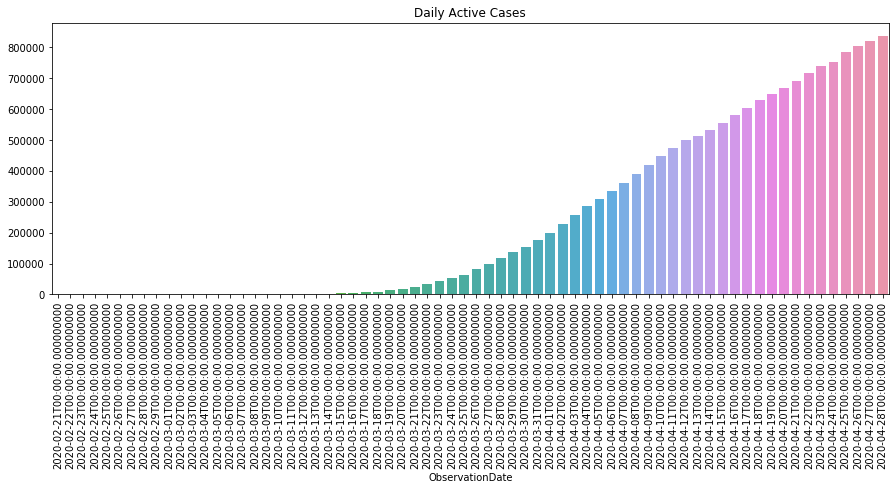

In [33]:
plt.figure(figsize=(15,5))
sns.barplot(x=datewise["ObservationDate"][30:], y=datewise["Confirmed"][30:]-datewise["Recovered"][30:]-datewise["Deaths"][30:])
plt.title("Daily Active Cases")
plt.xticks(rotation=90)



(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67]),
 <a list of 68 Text xticklabel objects>)

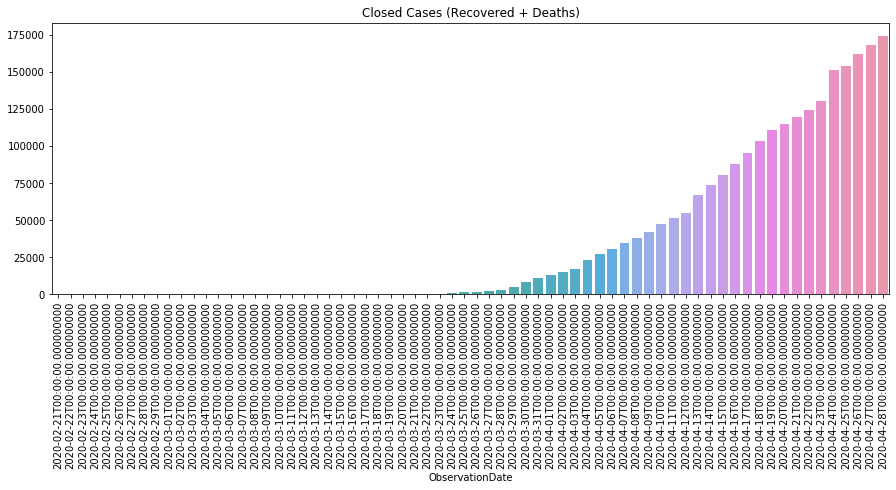

In [34]:
plt.figure(figsize=(15,5))
sns.barplot(x=datewise["ObservationDate"][30:], y=datewise["Recovered"][30:]+datewise["Deaths"][30:])
plt.title("Closed Cases (Recovered + Deaths)")
plt.xticks(rotation=90)


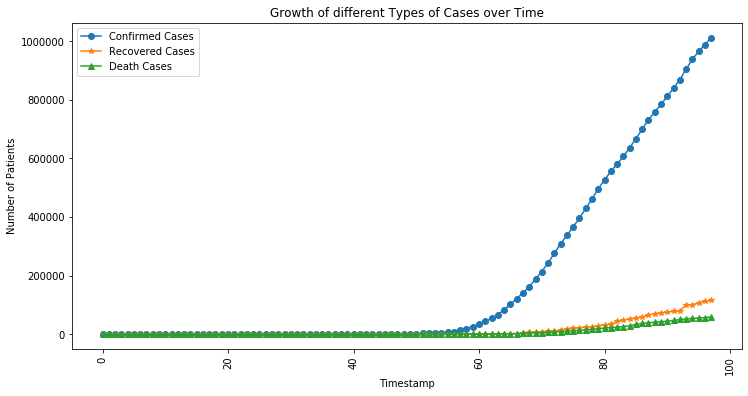

In [35]:
plt.figure(figsize=(12,6))
plt.plot(datewise["Confirmed"],marker="o",label="Confirmed Cases")
plt.plot(datewise["Recovered"],marker="*",label="Recovered Cases")
plt.plot(datewise["Deaths"],marker="^",label="Death Cases")
plt.ylabel("Number of Patients")
plt.xlabel("Timestamp")
plt.xticks(rotation=90)
plt.title("Growth of different Types of Cases over Time")
plt.legend()


#### Mortality rate and Recovery Rate Analysis
Mortality rate = (Number of Death Cases / Number of Confirmed Cases) x 100


Recovery Rate= (Number of Recoverd Cases / Number of Confirmed Cases) x 100


Average Mortality Rate 2.0837672704739485
Median Mortality Rate 1.535385277814075
Average Recovery Rate 2.2863079142314673
Median Recovery Rate 0.0


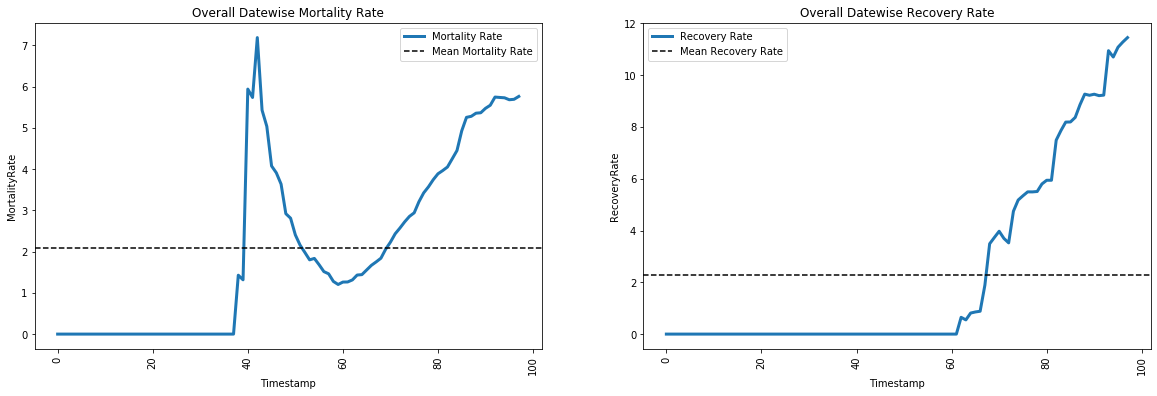

In [36]:
#Calculating the Mortality Rate and Recovery Rate
datewise["MortalityRate"]=(datewise["Deaths"]/datewise["Confirmed"])*100
datewise["RecoveryRate"]=(datewise["Recovered"]/datewise["Confirmed"])*100
datewise["ClosedCases"]=datewise["Recovered"]+datewise["Deaths"]

#Plotting Mortality and Recovery Rate 
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,6))
ax1.plot(datewise["MortalityRate"],label='Mortality Rate',linewidth=3)
ax1.axhline(datewise["MortalityRate"].mean(),linestyle='--',color='black',label="Mean Mortality Rate")
ax1.set_ylabel("MortalityRate")
ax1.set_xlabel("Timestamp")
ax1.set_title("Overall Datewise Mortality Rate")
ax1.legend()
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)
ax2.plot(datewise["RecoveryRate"],label="Recovery Rate",linewidth=3)
ax2.axhline(datewise["RecoveryRate"].mean(),linestyle='--',color='black',label="Mean Recovery Rate")
ax2.set_ylabel("RecoveryRate")
ax2.set_xlabel("Timestamp")
ax2.set_title("Overall Datewise Recovery Rate")
ax2.legend()
for tick in ax2.get_xticklabels():
    tick.set_rotation(90)
    
print("Average Mortality Rate",datewise["MortalityRate"].mean())
print("Median Mortality Rate",datewise["MortalityRate"].median())
print("Average Recovery Rate",datewise["RecoveryRate"].mean())
print("Median Recovery Rate",datewise["RecoveryRate"].median())


In [37]:
datewise["Recovered"].diff().tail()

93    18876.0
94     1293.0
95     6616.0
96     4436.0
97     4512.0
Name: Recovered, dtype: float64

In [38]:
datewise["Recovered"].tail()

93     99079.0
94    100372.0
95    106988.0
96    111424.0
97    115936.0
Name: Recovered, dtype: float64

#### Average daily Increase in Cases

Average increase in number of Confirmed Cases every day:  10439.0
Average increase in number of Recovered Cases every day:  1195.0
Average increase in number of Deaths Cases every day:  602.0


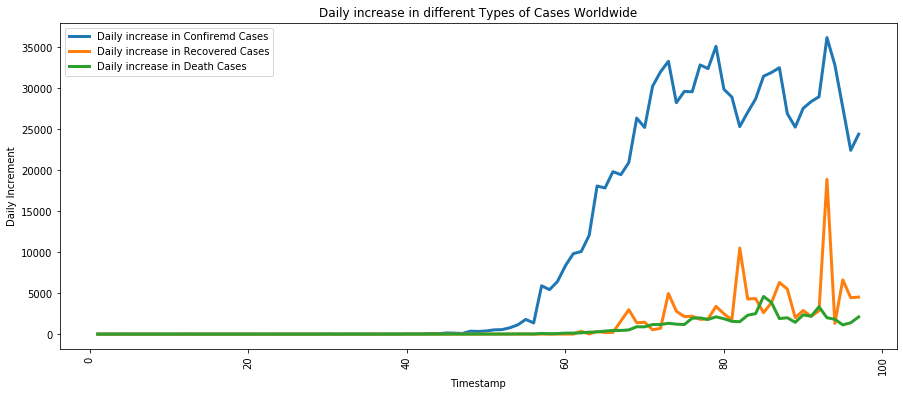

In [39]:
print("Average increase in number of Confirmed Cases every day: ",np.round(datewise["Confirmed"].diff().mean()))
print("Average increase in number of Recovered Cases every day: ",np.round(datewise["Recovered"].diff().mean()))
print("Average increase in number of Deaths Cases every day: ",np.round(datewise["Deaths"].diff().mean()))

plt.figure(figsize=(15,6))
plt.plot(datewise["Confirmed"].diff(),label="Daily increase in Confiremd Cases",linewidth=3)
plt.plot(datewise["Recovered"].diff(),label="Daily increase in Recovered Cases",linewidth=3)
plt.plot(datewise["Deaths"].diff(),label="Daily increase in Death Cases",linewidth=3)
plt.xlabel("Timestamp")
plt.ylabel("Daily Increment")
plt.title("Daily increase in different Types of Cases Worldwide")
plt.xticks(rotation=90)
plt.legend()

#### Rate of 100k Increase of Confirmed Cases

In [40]:
c=10000
double_days=[]
C=[]
counterdays=0
maxi=datewise["Confirmed"].max()

for i in list(datewise["Confirmed"]):
    if i <= c:
#         print("a")
        counterdays+=1
    else:
        double_days.append((c,counterdays))
        c=c+100000
        counterdays+=1
#     
#     if c < maxi:
#         continue
#     else:
#         break
#     counterdays+=1
double_days.append((c,counterdays))






In [41]:
df=pd.DataFrame(double_days, columns=["Rate 100k", "Days Since"])
df["Number of Days to Double"]=df["Days Since"].diff()

In [42]:
df.head()

,Rate 100k,Days Since,Number of Days to Double
0,10000,57,NaN
1,110000,66,9.0
2,210000,70,4.0
3,310000,74,4.0
4,410000,77,3.0


In [43]:
df["Number of Days to Double"].fillna(df["Days Since"].iloc[0],inplace=True)
df["Number of Days to Double"]=df["Number of Days to Double"].apply(lambda x:int(x))

In [44]:
df.head()

,Rate 100k,Days Since,Number of Days to Double
0,10000,57,57
1,110000,66,9
2,210000,70,4
3,310000,74,4
4,410000,77,3


Text(0.5, 1.0, 'Days required for rise in cases by 100K')

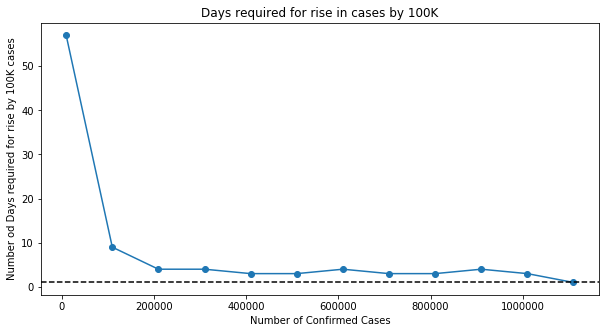

In [45]:
plt.figure(figsize=(10,5))
plt.plot(df["Rate 100k"], df["Number of Days to Double"],marker='o')
plt.axhline(1,color='black',linestyle='--')
plt.ylabel("Number od Days required for rise by 100K cases")
plt.xlabel("Number of Confirmed Cases")
plt.title("Days required for rise in cases by 100K")

### Statewise Analysis

In [46]:
covid_data_us.tail(2)

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
19601,19602,2020-04-28,Wisconsin,US,2020-04-29 02:32:29,6289.0,300.0,0.0
19602,19603,2020-04-28,Wyoming,US,2020-04-29 02:32:29,536.0,7.0,0.0


In [47]:
statewise=covid_data_us[covid_data_us["ObservationDate"]==covid_data_us["ObservationDate"].max()].groupby(["Province/State"]).agg({"Confirmed":'sum',"Deaths":'sum'}).sort_values(["Confirmed"],ascending=False)
statewise["Mortality"]=(statewise["Deaths"]/statewise["Confirmed"])*100
# statewise["Recovery"]=(statewise["Recovered"]/statewise["Confirmed"])*100

In [48]:
statewise.head()

,Confirmed,Deaths,Mortality
Province/State,,,
New York,295106.0,22912.0,7.763990
New Jersey,113856.0,6442.0,5.658024
Massachusetts,58302.0,3153.0,5.408048
Illinois,48102.0,2125.0,4.417696
California,46164.0,1864.0,4.037778


Text(0.5, 1.0, 'Top 15 States as per Number of Death Cases')

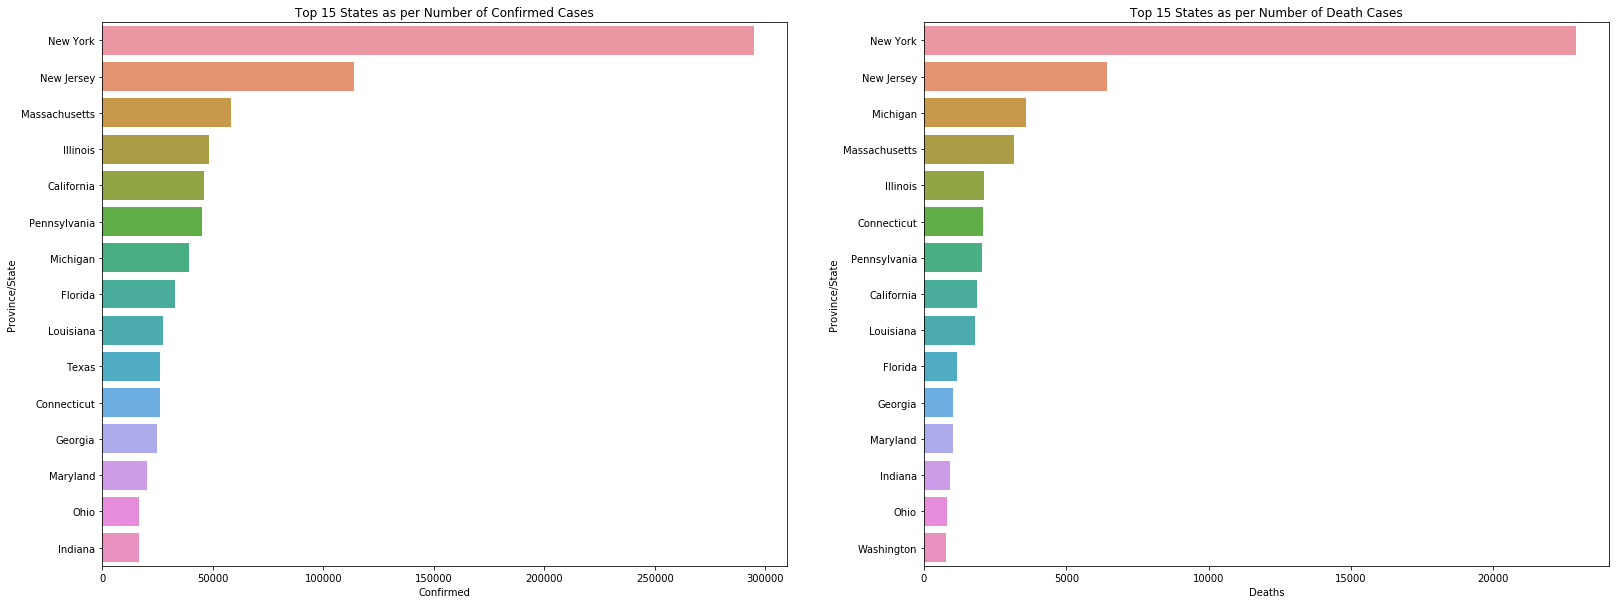

In [49]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(27,10))
top_15_confirmed=statewise.sort_values(["Confirmed"],ascending=False).head(15)
top_15_deaths=statewise.sort_values(["Deaths"],ascending=False).head(15)
sns.barplot(x=top_15_confirmed["Confirmed"],y=top_15_confirmed.index,ax=ax1)
ax1.set_title("Top 15 States as per Number of Confirmed Cases")
sns.barplot(x=top_15_deaths["Deaths"],y=top_15_deaths.index,ax=ax2)
ax2.set_title("Top 15 States as per Number of Death Cases")

#### Clustering of States

In [50]:
statewise.head()

,Confirmed,Deaths,Mortality
Province/State,,,
New York,295106.0,22912.0,7.763990
New Jersey,113856.0,6442.0,5.658024
Massachusetts,58302.0,3153.0,5.408048
Illinois,48102.0,2125.0,4.417696
California,46164.0,1864.0,4.037778


In [51]:
X = statewise[["Confirmed","Deaths"]].reset_index(drop=True)

In [52]:
X = StandardScaler().fit_transform(X)

In [53]:
wcss=[]
sil=[]
for i in range(2,11):
    clf=KMeans(n_clusters=i,init='k-means++',random_state=42)
    clf.fit(X)
    labels=clf.labels_
    centroids=clf.cluster_centers_
    sil.append(silhouette_score(X, labels, metric='euclidean'))
    wcss.append(clf.inertia_)


In [54]:
labels
centroids

array([[-0.38763457, -0.31249674],
       [ 6.6334041 ,  7.00176203],
       [ 2.2982977 ,  1.73322132],
       [ 0.24582115, -0.01549488],
       [ 0.96956666,  0.68111261],
       [-0.04233686, -0.07531377],
       [ 0.68651511,  0.31601479],
       [ 0.51417121,  0.81386577],
       [-0.27249095, -0.25123036],
       [ 0.21608331,  0.2943691 ]])

Text(0.5, 1.0, 'Silhouette Score Method')

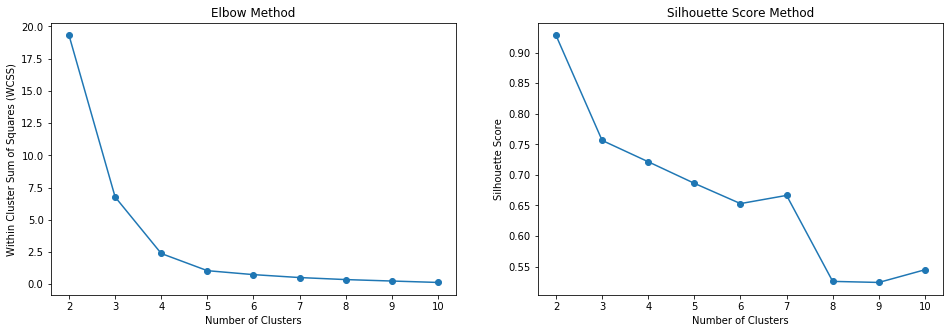

In [55]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,5))
x=np.arange(2,11)
ax1.plot(x,wcss,marker='o')
ax1.set_xlabel("Number of Clusters")
ax1.set_ylabel("Within Cluster Sum of Squares (WCSS)")
ax1.set_title("Elbow Method")
x=np.arange(2,11)
ax2.plot(x,sil,marker='o')
ax2.set_xlabel("Number of Clusters")
ax2.set_ylabel("Silhouette Score")
ax2.set_title("Silhouette Score Method")

We can see that at k =3 we get the elbow curve in Elbow method and maximum similarity from Silhoutte Method.
So According to the Elbow Method and Silhouette Method, Number of Clusters = 3

In [56]:
clf_final=KMeans(n_clusters=3,init='k-means++',random_state=42)
clf_final.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

#### Summary of clusters of each state

In [57]:
statewise["Clusters"]=clf_final.predict(X)


In [58]:
statewise.head(10)

,Confirmed,Deaths,Mortality,Clusters
Province/State,,,,
New York,295106.0,22912.0,7.763990,1
New Jersey,113856.0,6442.0,5.658024,2
Massachusetts,58302.0,3153.0,5.408048,2
Illinois,48102.0,2125.0,4.417696,2
California,46164.0,1864.0,4.037778,2
Pennsylvania,45137.0,2046.0,4.532867,2
Michigan,39262.0,3568.0,9.087667,2
Florida,32848.0,1171.0,3.564905,0
Louisiana,27286.0,1801.0,6.600454,0


Cluster 0 is a set of states which are moderately or very less affected, Cluster 2 is set of states which are severly affected, and Cluster 1 belongs to states which are worst affected. 

#### Scatter Plot of Clusters

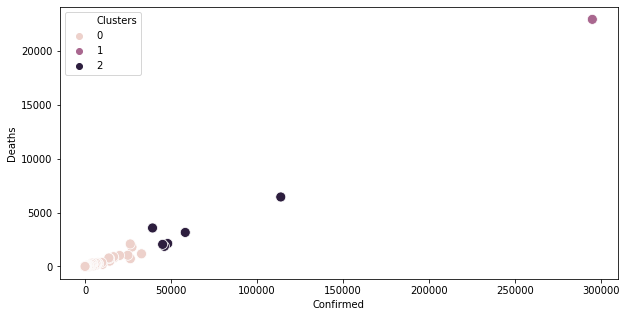

In [59]:
plt.figure(figsize=(10,5))
sns.scatterplot(x=statewise["Confirmed"],y=statewise["Deaths"],hue=statewise["Clusters"],s=100)

## B:- SEIRD MODEL :- Simulation Modelling

In [60]:
beds = pd.read_csv("https://raw.githubusercontent.com/hf2000510/infectious_disease_modelling/master/data/beds.csv", header=0)
agegroups = pd.read_csv("https://raw.githubusercontent.com/hf2000510/infectious_disease_modelling/master/data/agegroups.csv")
probabilities = pd.read_csv("https://raw.githubusercontent.com/hf2000510/infectious_disease_modelling/master/data/probabilities.csv")
#covid_data = pd.read_csv("https://tinyurl.com/t59cgxn", parse_dates=["Date"], skiprows=[1])
#covid_data["Location"] = covid_data["Country/Region"]


In [61]:
beds.head()
beds_us=beds[beds["Country"]=="United States"]

In [62]:
beds.head()

,Country,Continent,ICU_Beds
0,Japan,Asia,7.3
1,South Korea,Asia,10.6
2,Russia,Europe,8.3
3,Germany,Europe,29.2
4,Austria,Europe,21.8


In [63]:
beds_us

,Country,Continent,ICU_Beds
31,United States,North America,34.7


In [64]:
age_us=agegroups[agegroups.Location =="US"]

In [65]:
age_us

,Unnamed: 0,Location,0_9,10_19,20_29,30_39,40_49,50_59,60_69,70_79,80_89,90_100,Total
232,232,US,39721000.0,42332000.0,46094000.0,44668000.0,40349000.0,42120000.0,38488000.0,24083000.0,10372000.0,2678000.0,330905000.0


In [66]:

covid_data_us.tail()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
19597,19598,2020-04-28,Virginia,US,2020-04-29 02:32:29,14339.0,492.0,0.0
19598,19599,2020-04-28,Washington,US,2020-04-29 02:32:29,13842.0,786.0,0.0
19599,19600,2020-04-28,West Virginia,US,2020-04-29 02:32:29,1095.0,38.0,0.0
19601,19602,2020-04-28,Wisconsin,US,2020-04-29 02:32:29,6289.0,300.0,0.0
19602,19603,2020-04-28,Wyoming,US,2020-04-29 02:32:29,536.0,7.0,0.0


In [67]:
us_per_date=pd.DataFrame(covid_data_us.groupby("ObservationDate")["Confirmed"].sum()).diff()

In [68]:
us_per_date.head()

,Confirmed
ObservationDate,
2020-01-22,NaN
2020-01-23,0.0
2020-01-24,1.0
2020-01-25,0.0
2020-01-26,3.0


In [69]:
# store the probabilities collected
prob_I_to_C_1 = list(probabilities.prob_I_to_ICU_1.values)
prob_I_to_C_2 = list(probabilities.prob_I_to_ICU_2.values)
prob_C_to_Death_1 = list(probabilities.prob_ICU_to_Death_1.values)
prob_C_to_Death_2 = list(probabilities.prob_ICU_to_Death_2.values)

In [70]:
probabilities.head()
# us_per_date.Confirmed.cumsum()

,Age,prob_I_to_ICU_1,prob_ICU_to_Death_1,prob_I_to_ICU_2,prob_ICU_to_Death_2
0,0_9,0.001,0.00,0.001,0.00
1,10_19,0.003,0.00,0.003,0.00
2,20_29,0.009,0.05,0.006,0.00
3,30_39,0.025,0.06,0.009,0.00
4,40_49,0.030,0.10,0.025,0.12


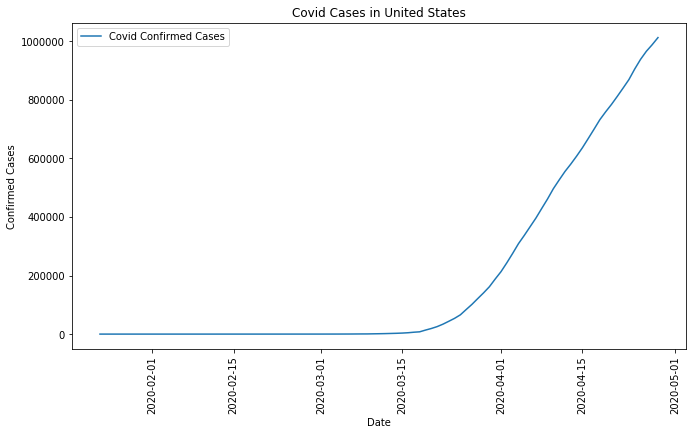

In [71]:
plt.figure(figsize=(11,6))
# plt.plot(X_test, y_pred, color='red', linewidth=2)
# plt.show()
plt.plot(us_per_date.Confirmed.cumsum(),label="Covid Confirmed Cases")
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.title("Covid Cases in United States")
plt.xticks(rotation=90)
plt.legend()



In [72]:
def deriv(y, t, beta, gamma, sigma, N, p_I_to_C, p_C_to_D, Beds):
    S, E, I, C, R, D = y

    dSdt = -beta(t) * I * S / N
    dEdt = beta(t) * I * S / N - sigma * E
    dIdt = sigma * E - 1/12.0 * p_I_to_C * I - gamma * (1 - p_I_to_C) * I
    dCdt = 1/12.0 * p_I_to_C * I - 1/7.5 * p_C_to_D * min(Beds(t), C) - max(0, C-Beds(t)) - (1 - p_C_to_D) * 1/6.5 * min(Beds(t), C)
    dRdt = gamma * (1 - p_I_to_C) * I + (1 - p_C_to_D) * 1/6.5 * min(Beds(t), C)
    dDdt = 1/7.5 * p_C_to_D * min(Beds(t), C) + max(0, C-Beds(t))
    return dSdt, dEdt, dIdt, dCdt, dRdt, dDdt

In [73]:
gamma = 1.0/9.0
sigma = 1.0/3.0

def logistic_R_0(t, R_0_start, k, x0, R_0_end):
    return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end

def Model(days, agegroups, beds_per_100k, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s):

    def beta(t):
        return logistic_R_0(t, R_0_start, k, x0, R_0_end) * gamma

    N = sum(agegroups)
    
    def Beds(t):
        beds_0 = beds_per_100k / 100_000 * N
        return beds_0 + s*beds_0*t  # 0.003

    y0 = N-1.0, 1.0, 0.0, 0.0, 0.0, 0.0
    t = np.linspace(0, days, days)
    ret = odeint(deriv, y0, t, args=(beta, gamma, sigma, N, prob_I_to_C, prob_C_to_D, Beds))
    S, E, I, C, R, D = ret.T
    R_0_over_time = [beta(i)/gamma for i in range(len(t))]

    return t, S, E, I, C, R, D, R_0_over_time, Beds, prob_I_to_C, prob_C_to_D

In [74]:
plt.gcf().subplots_adjust(bottom=0.15)

def plotter(t, S, E, I, C, R, D, R_0, B, S_1=None, S_2=None, x_ticks=None):
    if S_1 is not None and S_2 is not None:
        print(f"percentage going to ICU: {S_1*100}; percentage dying in ICU: {S_2 * 100}")


    f, ax = plt.subplots(1,1,figsize=(10,4))
    if x_ticks is None:
        ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(t, C, 'r--', alpha=0.7, linewidth=2, label='Critical')
        ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
        ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
    else:
        ax.plot(x_ticks, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(x_ticks, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(x_ticks, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(x_ticks, C, 'r--', alpha=0.7, linewidth=2, label='Critical')
        ax.plot(x_ticks, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
        ax.plot(x_ticks, D, 'k', alpha=0.7, linewidth=2, label='Dead')

        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()


    ax.title.set_text('extended SEIR-Model')

    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    plt.show();
    
    f = plt.figure(figsize=(10,4))
    # sp1
    ax1 = f.add_subplot(131)
    if x_ticks is None:
        ax1.plot(t, R_0, 'b--', alpha=0.7, linewidth=2, label='R_0')
    else:
        ax1.plot(x_ticks, R_0, 'b--', alpha=0.7, linewidth=2, label='R_0')
        ax1.xaxis.set_major_locator(mdates.YearLocator())
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax1.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()

 
    ax1.title.set_text('R_0 over time')
    ax1.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax1.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    
    # sp2
    ax2 = f.add_subplot(132)
    total_CFR = [0] + [100 * D[i] / sum(sigma*E[:i]) if sum(sigma*E[:i])>0 else 0 for i in range(1, len(t))]
    daily_CFR = [0] + [100 * ((D[i]-D[i-1]) / ((R[i]-R[i-1]) + (D[i]-D[i-1]))) if max((R[i]-R[i-1]), (D[i]-D[i-1]))>10 else 0 for i in range(1, len(t))]
    if x_ticks is None:
        ax2.plot(t, total_CFR, 'r--', alpha=0.7, linewidth=2, label='total')
        ax2.plot(t, daily_CFR, 'b--', alpha=0.7, linewidth=2, label='daily')
    else:
        ax2.plot(x_ticks, total_CFR, 'r--', alpha=0.7, linewidth=2, label='total')
        ax2.plot(x_ticks, daily_CFR, 'b--', alpha=0.7, linewidth=2, label='daily')
        ax2.xaxis.set_major_locator(mdates.YearLocator())
        ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax2.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()

    ax2.title.set_text('Fatality Rate (%)')
    ax2.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax2.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    # sp3
    ax3 = f.add_subplot(133)
    newDs = [0] + [D[i]-D[i-1] for i in range(1, len(t))]
    if x_ticks is None:
        ax3.plot(t, newDs, 'r--', alpha=0.7, linewidth=2, label='total')
        ax3.plot(t, [max(0, C[i]-B(i)) for i in range(len(t))], 'b--', alpha=0.7, linewidth=2, label="over capacity")
    else:
        ax3.plot(x_ticks, newDs, 'r--', alpha=0.7, linewidth=2, label='total')
        ax3.plot(x_ticks, [max(0, C[i]-B(i)) for i in range(len(t))], 'b--', alpha=0.7, linewidth=2, label="over capacity")
        ax3.xaxis.set_major_locator(mdates.YearLocator())
        ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax3.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()

    ax3.title.set_text('Deaths per day')
    ax3.yaxis.set_tick_params(length=0)
    ax3.xaxis.set_tick_params(length=0)
    ax3.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax3.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)



<Figure size 432x288 with 0 Axes>


### Fitting US Data in SEIR Model

In [75]:
data = np.array(us_per_date["Confirmed"].dropna().astype("int"))

In [76]:
agegrp_us = np.array(age_us.iloc[0][2:-1].astype("int"))

In [77]:
beds_per_100k = beds_us["ICU_Beds"].iloc[0]

In [78]:
# parameters
outbreak_shift = -30
params_init_min_max = {"R_0_start": (3.0, 2.0, 5.0), "k": (2.5, 0.01, 5.0), "x0": (90, 0, 120), "R_0_end": (0.9, 0.3, 3.5),
                       "prob_I_to_C": (0.05, 0.01, 0.1), "prob_C_to_D": (0.5, 0.05, 0.8),
                       "s": (0.003, 0.001, 0.01)}  # form: {parameter: (initial guess, minimum value, max value)}

In [79]:
days = outbreak_shift + len(data)
if outbreak_shift >= 0:
    y_data = np.concatenate((np.zeros(outbreak_shift), data))
else:
    y_data = data[-outbreak_shift:]

x_data = np.linspace(0, days - 1, days, dtype=int)  # x_data is just [0, 1, ..., max_days] array

def fitter(x, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s):
    ret = Model(days, agegrp_us, beds_per_100k, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s)
    return ret[6][x]

In [80]:
mod = lmfit.Model(fitter)

for kwarg, (init, mini, maxi) in params_init_min_max.items():
    mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)

params = mod.make_params()
fit_method = "leastsq"

In [81]:
result = mod.fit(y_data, params, method="least_squares", x=x_data)

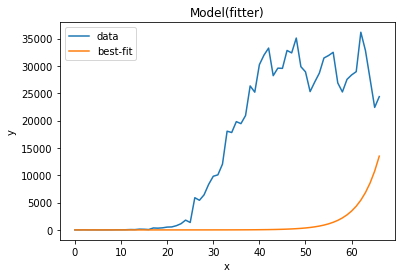

In [82]:
result.plot_fit(datafmt="-");

In [83]:
result.best_values

{'R_0_start': 4.999999999152443,
 'k': 4.951181662146407,
 'x0': 106.02137504387957,
 'R_0_end': 0.721482578296621,
 'prob_I_to_C': 0.09999999999999999,
 'prob_C_to_D': 0.7999999998646359,
 's': 0.003}

Prediction for US
percentage going to ICU: 10.0; percentage dying in ICU: 79.99999998646359


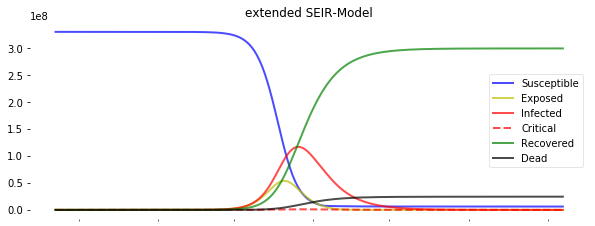

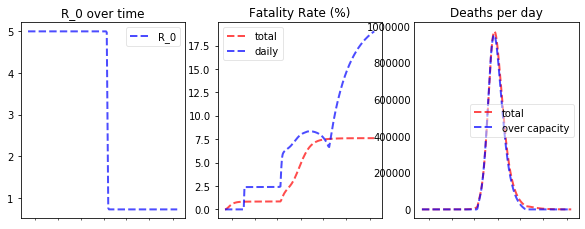

In [84]:
full_days = 200
first_date = np.datetime64(us_per_date.index.min()) - np.timedelta64(outbreak_shift,'D')
x_ticks = pd.date_range(start=first_date, periods=full_days, freq="D")
print("Prediction for US")
plotter(*Model(full_days,agegrp_us, beds_per_100k, **result.best_values), x_ticks=x_ticks);

In [85]:
us_per_date.index.min()

Timestamp('2020-01-22 00:00:00')

## C. Prediction using Machine Learning Models

Linear Regression Model for Confirmed Cases Prediction


In [86]:
datewise.head(15)

,Confirmed,Deaths,ObservationDate,Recovered,Active,MortalityRate,RecoveryRate,ClosedCases
0,1.0,0.0,2020-01-22,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,2020-01-23,0.0,1.0,0.0,0.0,0.0
2,2.0,0.0,2020-01-24,0.0,2.0,0.0,0.0,0.0
3,2.0,0.0,2020-01-25,0.0,2.0,0.0,0.0,0.0
4,5.0,0.0,2020-01-26,0.0,5.0,0.0,0.0,0.0
5,5.0,0.0,2020-01-27,0.0,5.0,0.0,0.0,0.0
6,5.0,0.0,2020-01-28,0.0,5.0,0.0,0.0,0.0
7,5.0,0.0,2020-01-29,0.0,5.0,0.0,0.0,0.0
8,5.0,0.0,2020-01-30,0.0,5.0,0.0,0.0,0.0
9,6.0,0.0,2020-01-31,0.0,6.0,0.0,0.0,0.0


In [87]:
datewise.sort_values(by=["ObservationDate"],ascending=True,inplace=True)
datewise["Days Since"]=datewise.index

In [88]:
datewise.head()

,Confirmed,Deaths,ObservationDate,Recovered,Active,MortalityRate,RecoveryRate,ClosedCases,Days Since
0,1.0,0.0,2020-01-22,0.0,1.0,0.0,0.0,0.0,0
1,1.0,0.0,2020-01-23,0.0,1.0,0.0,0.0,0.0,1
2,2.0,0.0,2020-01-24,0.0,2.0,0.0,0.0,0.0,2
3,2.0,0.0,2020-01-25,0.0,2.0,0.0,0.0,0.0,3
4,5.0,0.0,2020-01-26,0.0,5.0,0.0,0.0,0.0,4


In [89]:
X=np.array(datewise["Days Since"]).reshape(-1,1)
y=np.array(datewise["Confirmed"]).reshape(-1,1)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
mod=LinearRegression()
mod.fit(X,y)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [90]:
y_pred = mod.predict(X)

#### Root Mean squared error

In [91]:
#Root Mean Square error
model_err={}
y_exp=np.array(datewise["Confirmed"])

y_pred=y_pred.flatten()
# y_d=(y_exp-y_pred)**2
# print("Root mean Square Error ",np.sqrt(np.mean(y_d)))
model_err.update({"Linear Regression" :np.sqrt(mean_squared_error(y_pred,y_exp))})
print("Root Mean Squared Error: ",np.sqrt(mean_squared_error(y_pred,y_exp)))


Root Mean Squared Error:  179241.2841306577


In [92]:
datewise.head()

,Confirmed,Deaths,ObservationDate,Recovered,Active,MortalityRate,RecoveryRate,ClosedCases,Days Since
0,1.0,0.0,2020-01-22,0.0,1.0,0.0,0.0,0.0,0
1,1.0,0.0,2020-01-23,0.0,1.0,0.0,0.0,0.0,1
2,2.0,0.0,2020-01-24,0.0,2.0,0.0,0.0,0.0,2
3,2.0,0.0,2020-01-25,0.0,2.0,0.0,0.0,0.0,3
4,5.0,0.0,2020-01-26,0.0,5.0,0.0,0.0,0.0,4


In [93]:
datewise["Confirmed"].unique()

array([1.000000e+00, 2.000000e+00, 5.000000e+00, 6.000000e+00,
       8.000000e+00, 1.100000e+01, 1.200000e+01, 1.300000e+01,
       1.500000e+01, 3.500000e+01, 5.300000e+01, 5.900000e+01,
       6.000000e+01, 6.200000e+01, 7.000000e+01, 7.600000e+01,
       1.010000e+02, 1.220000e+02, 1.530000e+02, 2.210000e+02,
       2.780000e+02, 4.170000e+02, 5.370000e+02, 6.050000e+02,
       9.590000e+02, 1.281000e+03, 1.663000e+03, 2.179000e+03,
       2.726000e+03, 3.499000e+03, 4.632000e+03, 6.421000e+03,
       7.786000e+03, 1.368000e+04, 1.910100e+04, 2.551400e+04,
       3.384800e+04, 4.366300e+04, 5.373600e+04, 6.577800e+04,
       8.383600e+04, 1.016570e+05, 1.214650e+05, 1.409090e+05,
       1.618310e+05, 1.881720e+05, 2.133720e+05, 2.435990e+05,
       2.755860e+05, 3.088530e+05, 3.370720e+05, 3.666670e+05,
       3.962230e+05, 4.290520e+05, 4.614370e+05, 4.965350e+05,
       5.263960e+05, 5.553130e+05, 5.806190e+05, 6.076700e+05,
       6.363500e+05, 6.678010e+05, 6.997060e+05, 7.3219

In [94]:
datewise["datetime"] = pd.to_datetime(datewise.ObservationDate)
datewise.set_index('datetime', inplace=True)

In [95]:
print(datewise.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 98 entries, 2020-01-22 to 2020-04-28
Data columns (total 9 columns):
Confirmed          98 non-null float64
Deaths             98 non-null float64
ObservationDate    98 non-null datetime64[ns]
Recovered          98 non-null float64
Active             98 non-null float64
MortalityRate      98 non-null float64
RecoveryRate       98 non-null float64
ClosedCases        98 non-null float64
Days Since         98 non-null int64
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 7.7 KB
None


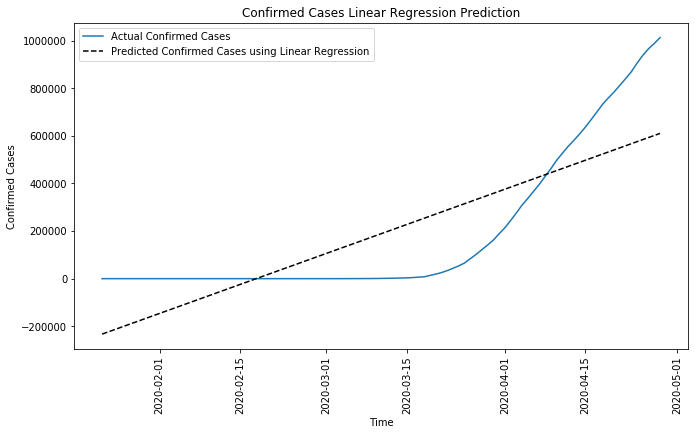

In [96]:
plt.figure(figsize=(11,6))
# plt.plot(X_test, y_pred, color='red', linewidth=2)
# plt.show()
plt.plot(datewise["Confirmed"],label="Actual Confirmed Cases")
plt.plot(datewise.index, y_pred, linestyle='--',label="Predicted Confirmed Cases using Linear Regression",color='black')
plt.xlabel('Time')
plt.ylabel('Confirmed Cases')
plt.title("Confirmed Cases Linear Regression Prediction")
plt.xticks(rotation=90)
plt.legend()



Note: From the above graph we can see that LinearRegression is not working as the Actual values are way different than Predicted values of the model

#### SVM Model Regressor

In [97]:
regressor = SVR(C=1,kernel='poly')
regressor.fit(X,y)


SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='poly', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [98]:
y_pred_svm = regressor.predict(X)

In [99]:
y_pred_svm

array([-40390.7362706 , -40389.64709262, -40382.02284677, -40361.32846522,
       -40321.02887999, -40254.58902346, -40155.47382753, -40017.14822476,
       -39833.07714575, -39596.7255246 , -39301.55829351, -38941.04038399,
       -38508.63672607, -37997.81225269, -37402.03190392, -36714.76059692,
       -35929.46327179, -35039.60486572, -34038.65030258, -32920.06452148,
       -31677.31245392, -30303.85903137, -28793.1691777 , -27138.70782822,
       -25333.9399144 , -23372.33037918, -21247.34412735, -18952.44615524,
       -16481.10133713, -13826.77458542, -10982.93088119,  -7943.03515976,
        -4700.55228012,  -1248.94731491,   2418.31496841,   6307.76952774,
        10425.95147354,  14779.39574844,  19374.63772232,  24218.21215469,
        29316.65426285,  34676.49911148,  40304.28164322,  46206.53710587,
        52389.80047257,  58860.60680801,  65625.49126846,  72690.98882706,
        80063.63457901,  87749.96361954,  95756.51086075, 104089.811642  ,
       112756.4008754 , 1

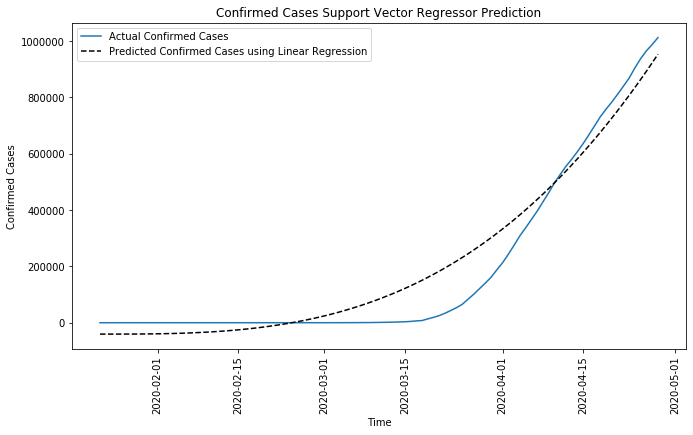

In [100]:
plt.figure(figsize=(11,6))
# plt.plot(X_test, y_pred, color='red', linewidth=2)
# plt.show()
plt.plot(datewise["Confirmed"],label="Actual Confirmed Cases")
plt.plot(datewise.index, y_pred_svm, linestyle='--',label="Predicted Confirmed Cases using Linear Regression",color='black')
plt.xlabel('Time')
plt.ylabel('Confirmed Cases')
plt.title("Confirmed Cases Support Vector Regressor Prediction")
plt.xticks(rotation=90)
plt.legend()



In [101]:
#y_exp=np.array(datewise["Confirmed"])

y_pred_svm=y_pred_svm.flatten()
# y_d=(y_exp-y_pred)**2
# print("Root mean Square Error ",np.sqrt(np.mean(y_d)))
model_err.update({"SVM Regressor" :np.sqrt(mean_squared_error(y_pred_svm,y_exp))})
print("Root Mean Squared Error: ",np.sqrt(mean_squared_error(y_pred_svm,y_exp)))

Root Mean Squared Error:  76909.09277820226


#### Adding predictions of both regression model in Dataframe

In [102]:
model_predictions = pd.DataFrame(columns=["Dates"])

In [103]:
datewise.index[-1]+timedelta(days=i)

Timestamp('2020-05-08 00:00:00')

In [104]:
predict=[]
for i in range(1,21):
    model_predictions = model_predictions.append(pd.DataFrame([datewise.index[-1]+timedelta(days=i)], columns=["Dates"]))
    predict.append(datewise["Days Since"][-1]+i)

In [105]:
model_predictions.reset_index(drop=True, inplace=True)

In [106]:
model_predictions["Linear Regression"]=mod.predict(np.array(predict).reshape(-1,1))

In [107]:
model_predictions.head()

,Dates,Linear Regression
0,2020-04-29,618999.668841
1,2020-04-30,627691.732858
2,2020-05-01,636383.796875
3,2020-05-02,645075.860892
4,2020-05-03,653767.924909


In [108]:
model_predictions["SVM"]=regressor.predict(np.array(predict).reshape(-1,1))

#### Time Series Forecasting
#### 1. Holt's Linear Trend Model

In [109]:
datewise.head()

,Confirmed,Deaths,ObservationDate,Recovered,Active,MortalityRate,RecoveryRate,ClosedCases,Days Since
datetime,,,,,,,,,
2020-01-22,1.0,0.0,2020-01-22,0.0,1.0,0.0,0.0,0.0,0
2020-01-23,1.0,0.0,2020-01-23,0.0,1.0,0.0,0.0,0.0,1
2020-01-24,2.0,0.0,2020-01-24,0.0,2.0,0.0,0.0,0.0,2
2020-01-25,2.0,0.0,2020-01-25,0.0,2.0,0.0,0.0,0.0,3
2020-01-26,5.0,0.0,2020-01-26,0.0,5.0,0.0,0.0,0.0,4


In [110]:
X_train=datewise.iloc[:int(datewise.shape[0]*0.90)]
X_validtesting=datewise.iloc[int(datewise.shape[0]*0.90):]


In [111]:
holt=Holt(X_train["Confirmed"])
holt=holt.fit(smoothing_level=0.2, smoothing_slope=0.2)



In [112]:
y_pred = X_validtesting.copy()
y_forecast=holt.forecast(len(X_validtesting))

In [113]:
y_forecast

2020-04-19    7.690883e+05
2020-04-20    8.011043e+05
2020-04-21    8.331203e+05
2020-04-22    8.651363e+05
2020-04-23    8.971522e+05
2020-04-24    9.291682e+05
2020-04-25    9.611842e+05
2020-04-26    9.932002e+05
2020-04-27    1.025216e+06
2020-04-28    1.057232e+06
Freq: D, dtype: float64

In [114]:
model_err.update({"Holt's Linear" : np.sqrt(mean_squared_error(y_pred["Confirmed"],y_forecast))})
print("Root Mean Squared Error: ",np.sqrt(mean_squared_error(y_pred["Confirmed"],y_forecast)))

Root Mean Squared Error:  27297.30950495782


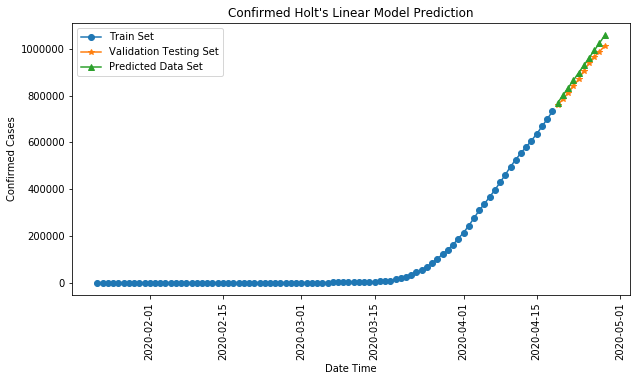

In [115]:
plt.figure(figsize=(10,5))
plt.plot(X_train["Confirmed"],label="Train Set",marker='o')
plt.plot(y_pred["Confirmed"],label="Validation Testing Set",marker='*')
plt.plot(y_forecast,label="Predicted Data Set",marker='^')
plt.ylabel("Confirmed Cases")
plt.xlabel("Date Time")
plt.title("Confirmed Holt's Linear Model Prediction")
plt.xticks(rotation=90)
plt.legend()




In [116]:
datewise.head()

,Confirmed,Deaths,ObservationDate,Recovered,Active,MortalityRate,RecoveryRate,ClosedCases,Days Since
datetime,,,,,,,,,
2020-01-22,1.0,0.0,2020-01-22,0.0,1.0,0.0,0.0,0.0,0
2020-01-23,1.0,0.0,2020-01-23,0.0,1.0,0.0,0.0,0.0,1
2020-01-24,2.0,0.0,2020-01-24,0.0,2.0,0.0,0.0,0.0,2
2020-01-25,2.0,0.0,2020-01-25,0.0,2.0,0.0,0.0,0.0,3
2020-01-26,5.0,0.0,2020-01-26,0.0,5.0,0.0,0.0,0.0,4


In [117]:
X_train=datewise.iloc[:int(datewise.shape[0]*0.90)]
X_validtesting=datewise.iloc[int(datewise.shape[0]*0.90):]


In [118]:
holt=Holt(X_train["Deaths"])
holt=holt.fit(smoothing_level=0.2, smoothing_slope=0.2)



In [119]:
y_pred = X_validtesting.copy()
y_forecast=holt.forecast(len(X_validtesting))

In [120]:
y_pred
y_forecast

2020-04-19    38020.311062
2020-04-20    40494.207431
2020-04-21    42968.103800
2020-04-22    45442.000169
2020-04-23    47915.896539
2020-04-24    50389.792908
2020-04-25    52863.689277
2020-04-26    55337.585646
2020-04-27    57811.482015
2020-04-28    60285.378384
Freq: D, dtype: float64

In [121]:
print("Root Mean Squared Error: ",np.sqrt(mean_squared_error(y_pred["Deaths"],y_forecast)))

Root Mean Squared Error:  1637.9164315305807


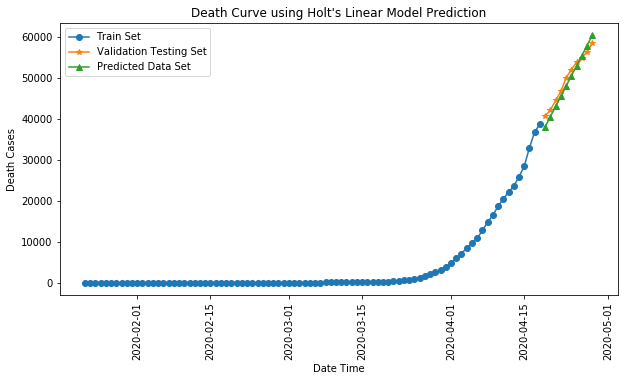

In [122]:
plt.figure(figsize=(10,5))
plt.plot(X_train["Deaths"],label="Train Set",marker='o')
plt.plot(y_pred["Deaths"],label="Validation Testing Set",marker='*')
plt.plot(y_forecast,label="Predicted Data Set",marker='^')
plt.ylabel("Death Cases")
plt.xlabel("Date Time")
plt.title("Death Curve using Holt's Linear Model Prediction")
plt.xticks(rotation=90)
plt.legend()

In [123]:
model_predictions.head(20)

,Dates,Linear Regression,SVM
0,2020-04-29,618999.668841,9.847349e+05
1,2020-04-30,627691.732858,1.016438e+06
2,2020-05-01,636383.796875,1.048787e+06
3,2020-05-02,645075.860892,1.081790e+06
4,2020-05-03,653767.924909,1.115454e+06
5,2020-05-04,662459.988926,1.149783e+06
6,2020-05-05,671152.052943,1.184786e+06
7,2020-05-06,679844.116960,1.220469e+06
8,2020-05-07,688536.180977,1.256838e+06
9,2020-05-08,697228.244994,1.293899e+06


In [124]:
model_predictions.shape

(20, 3)

In [125]:
model_predictions["Holt's Linear Model Prediction"]=np.array(holt.forecast(len(y_pred)+20)[-20:])

In [126]:
model_predictions.head()

,Dates,Linear Regression,SVM,Holt's Linear Model Prediction
0,2020-04-29,618999.668841,9.847349e+05,62759.274753
1,2020-04-30,627691.732858,1.016438e+06,65233.171122
2,2020-05-01,636383.796875,1.048787e+06,67707.067491
3,2020-05-02,645075.860892,1.081790e+06,70180.963860
4,2020-05-03,653767.924909,1.115454e+06,72654.860229


#### ARIMA MODEL
ARIMA Itself comprises of AR(Auto Regression) and MA(Moving Average)
I stands for integration.
We will first compute results of AR models and MA models and then for better results we will implement ARIMA as a whole.
#### 1. AR MODEL

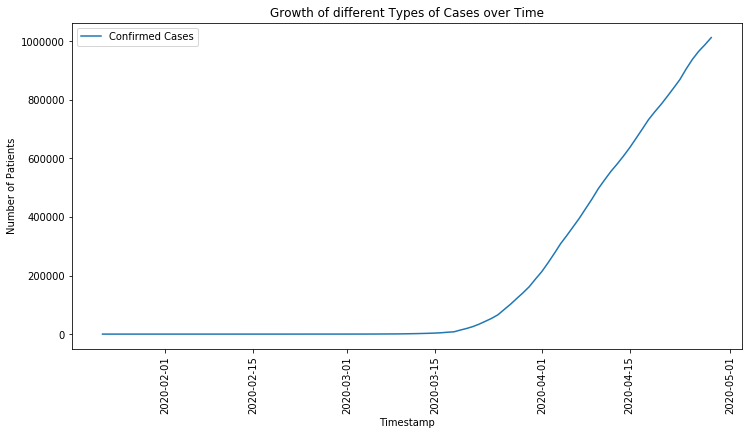

In [127]:
plt.figure(figsize=(12,6))
plt.plot(datewise["Confirmed"],label="Confirmed Cases")
plt.ylabel("Number of Patients")
plt.xlabel("Timestamp")
plt.xticks(rotation=90)
plt.title("Growth of different Types of Cases over Time")
plt.legend()


#### Checking the Data on the basis of Trend, Seasonality, Observed, Residual(Noise/Irregularity)

#### A. Using Visualization

In [130]:
datewise.head()

,Confirmed,Deaths,ObservationDate,Recovered,Active,MortalityRate,RecoveryRate,ClosedCases,Days Since
datetime,,,,,,,,,
2020-01-22,1.0,0.0,2020-01-22,0.0,1.0,0.0,0.0,0.0,0
2020-01-23,1.0,0.0,2020-01-23,0.0,1.0,0.0,0.0,0.0,1
2020-01-24,2.0,0.0,2020-01-24,0.0,2.0,0.0,0.0,0.0,2
2020-01-25,2.0,0.0,2020-01-25,0.0,2.0,0.0,0.0,0.0,3
2020-01-26,5.0,0.0,2020-01-26,0.0,5.0,0.0,0.0,0.0,4


In [133]:
pd.plotting.register_matplotlib_converters()

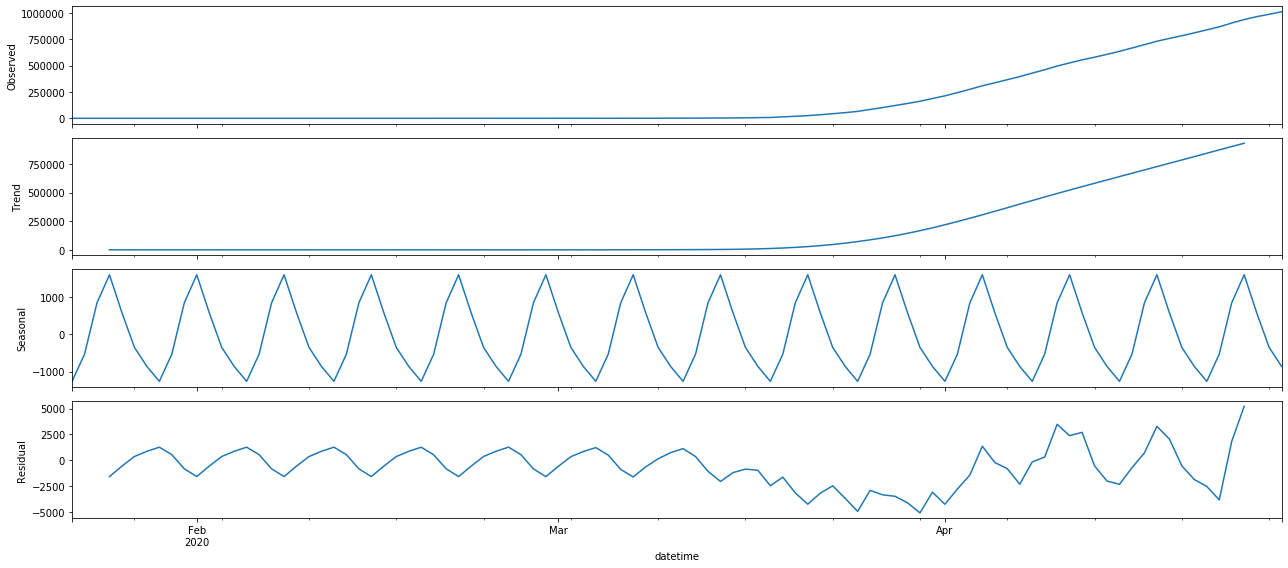

In [134]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(datewise["Confirmed"].astype("int"), model='additive')
fig = decomposition.plot()
plt.show()

#### B. Using Dickey Fuller Test
Determining Rolling Statistics

In [135]:
# datewise["Confirmed"].rolling(12).std()

In [136]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    rolmean = timeseries.rolling(12).mean() #Rollling Average in dataset
    rolstd = timeseries.rolling(12).std() #Rolling Standard Deviation in Dataset
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    print(dftest)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

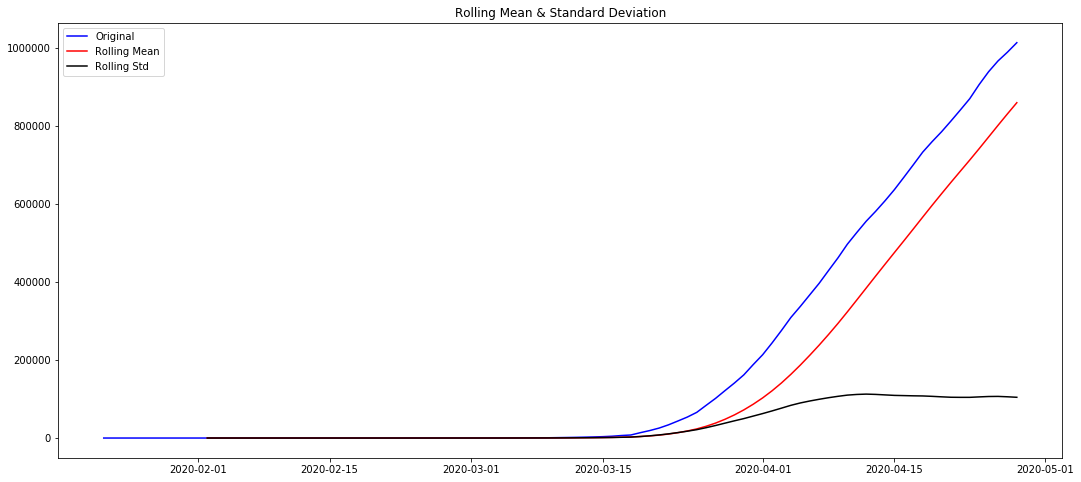

Results of Dickey-Fuller Test:
(-1.1111540172278438, 0.7106033762256079, 12, 85, {'1%': -3.5097356063504983, '5%': -2.8961947486260944, '10%': -2.5852576124567475}, 1488.2479018752283)
Test Statistic                 -1.111154
p-value                         0.710603
#Lags Used                     12.000000
Number of Observations Used    85.000000
Critical Value (1%)            -3.509736
Critical Value (5%)            -2.896195
Critical Value (10%)           -2.585258
dtype: float64


In [137]:
test_stationarity(datewise["Confirmed"])

We can see that p-value is greater than 0.5. We fail to reject the null hypothesis. So the Data is not stationary.

From the above graph variance is smallbut mean is not constant throughout the data. 
To make the Data stationary we will transform the data set by:

1. Taking Logarithm
2. Subtracting Moving average from the data set

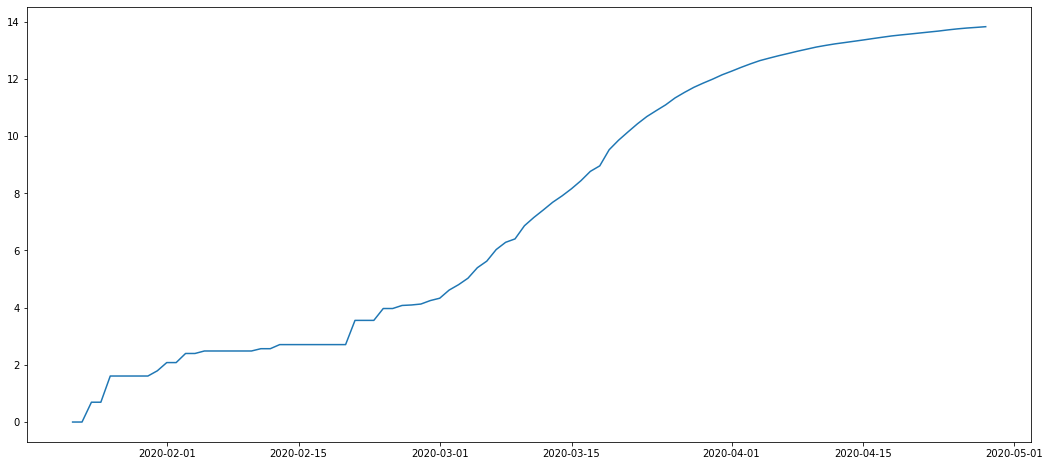

In [138]:
log_confirmed_data = np.log(datewise["Confirmed"])
plt.plot(np.log(datewise["Confirmed"]))


##### Testing by taking the Moving Average and subtracting from Log Values of Dataset

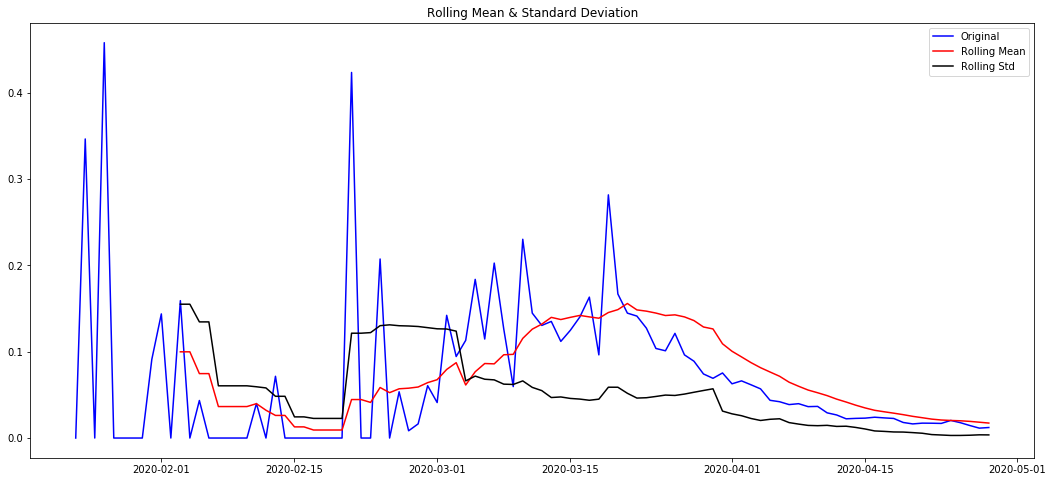

Results of Dickey-Fuller Test:
(-3.036071916228506, 0.03166031258698449, 2, 94, {'1%': -3.5019123847798657, '5%': -2.892815255482889, '10%': -2.583453861475781}, -228.34707059577295)
Test Statistic                 -3.036072
p-value                         0.031660
#Lags Used                      2.000000
Number of Observations Used    94.000000
Critical Value (1%)            -3.501912
Critical Value (5%)            -2.892815
Critical Value (10%)           -2.583454
dtype: float64


In [139]:
log_rolmean = log_confirmed_data.rolling(2).mean() #Rollling Average in dataset
diff_logConf_rolmean =  log_confirmed_data - log_rolmean
diff_logConf_rolmean = diff_logConf_rolmean.dropna()
test_stationarity(diff_logConf_rolmean)

##### Observations

1. p-value is still high and also the Test Statistics and Critical Values are not equal. Therefore, this transformation will not work.
2. Applying diff() - Find discrete difference

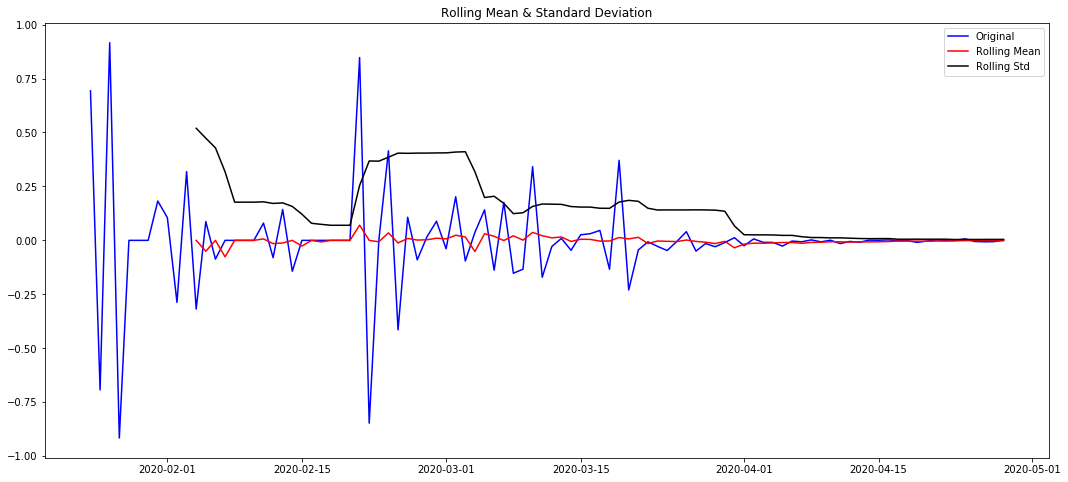

Results of Dickey-Fuller Test:
(-12.585439975773342, 1.870401882961233e-23, 1, 94, {'1%': -3.5019123847798657, '5%': -2.892815255482889, '10%': -2.583453861475781}, -107.24939062802267)
Test Statistic                -1.258544e+01
p-value                        1.870402e-23
#Lags Used                     1.000000e+00
Number of Observations Used    9.400000e+01
Critical Value (1%)           -3.501912e+00
Critical Value (5%)           -2.892815e+00
Critical Value (10%)          -2.583454e+00
dtype: float64


In [140]:
discrete_diff = log_confirmed_data.diff().diff().dropna()
test_stationarity(discrete_diff)

##### Observation:- 

p-value has almost become 0 and therefore, we can reject the null hypothesis and by performing the transformations we have made the data stationary and ready to use in ARIMA Model.


 ReVisualizing the Trend, Observed, Seasonality, Residual of discrete-discrete log data sets

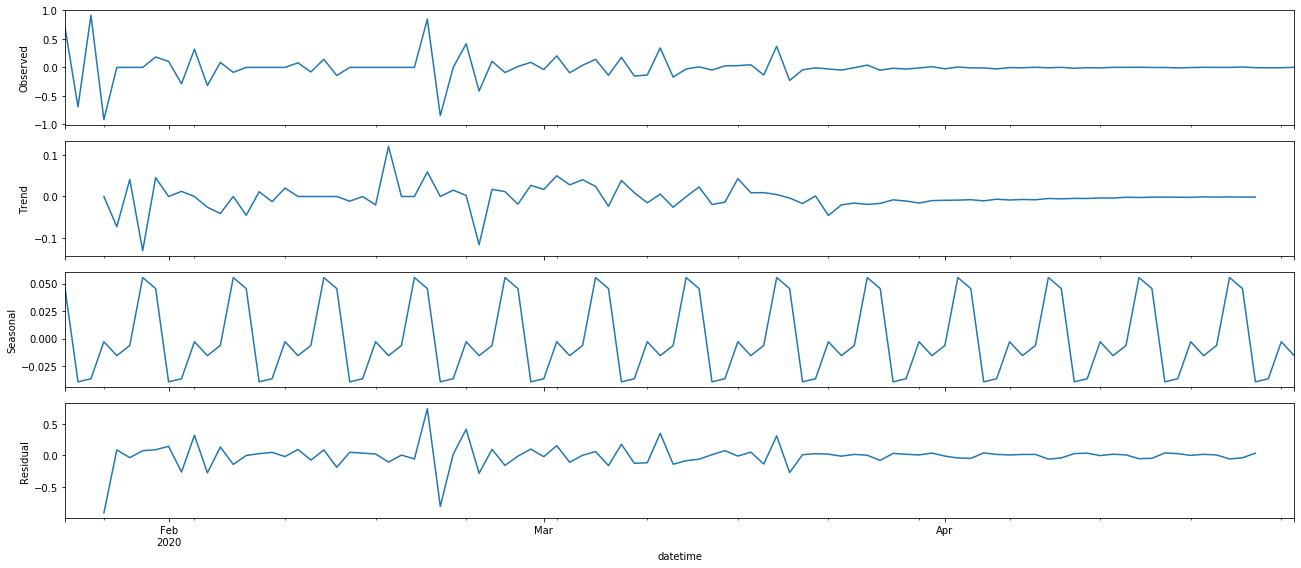

In [141]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(discrete_diff, model='additive')
fig = decomposition.plot()
plt.show()

In [142]:
from statsmodels.tsa.stattools import acf, pacf

In [143]:
lag_acf = acf(discrete_diff, nlags=20)
lag_pacf = pacf(discrete_diff, method='ols')

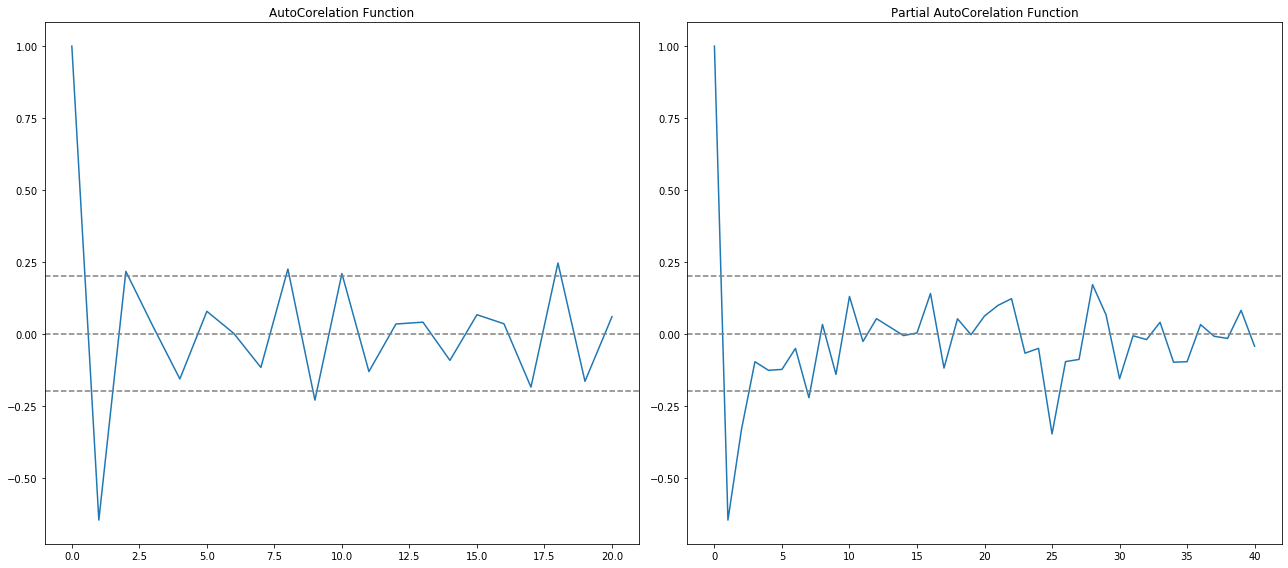

In [144]:
# Plot ACF

plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle="--", color="gray")
plt.axhline(y=-1.96/np.sqrt(len(discrete_diff)), linestyle="--", color="gray")
plt.axhline(y=1.96/np.sqrt(len(discrete_diff)), linestyle="--", color="gray")
plt.title("AutoCorelation Function")


plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle="--", color="gray")
plt.axhline(y=-1.96/np.sqrt(len(discrete_diff)), linestyle="--", color="gray")
plt.axhline(y=1.96/np.sqrt(len(discrete_diff)), linestyle="--", color="gray")
plt.title("Partial AutoCorelation Function")
plt.tight_layout()

#### AR Model

In [145]:
X_train=datewise.iloc[:int(datewise.shape[0]*0.90)]
X_validtesting=datewise.iloc[int(datewise.shape[0]*0.90):]

In [146]:
log_train = np.log(X_train["Confirmed"])

In [147]:
model_ar=ARIMA(log_train,(1,2,0))
model_ar_fit=model_ar.fit()

In [148]:
prediction_ar=model_ar_fit.forecast(len(X_validtesting))[0]
# model_predictions["AR Model Prediction"]=list(np.exp(prediction_ar))


In [149]:
prediction_ar

array([13.54529943, 13.5847337 , 13.62082027, 13.65446262, 13.68502671,
       13.71295749, 13.73794271, 13.7602015 , 13.77958008, 13.79618636])

In [150]:
# model_scores.append(np.sqrt(mean_squared_error(list(y_pred["Confirmed"]),np.exp(prediction_ar))))
model_err.update({"AR Model" :np.sqrt(mean_squared_error(list(X_validtesting["Confirmed"]),np.exp(prediction_ar)))})
print("Root Mean Square Error for AR Model: ",np.sqrt(mean_squared_error(list(X_validtesting["Confirmed"]),np.exp(prediction_ar))))


Root Mean Square Error for AR Model:  15944.200267095406


(array([737456., 737470., 737485., 737499., 737516., 737530., 737546.]),
 <a list of 7 Text xticklabel objects>)

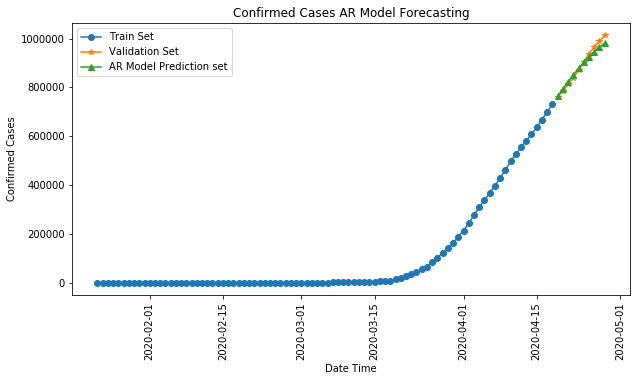

In [151]:
plt.figure(figsize=(10,5))
plt.plot(X_train.index,X_train["Confirmed"],label="Train Set",marker='o')
plt.plot(X_validtesting.index,X_validtesting["Confirmed"],label="Validation Set",marker='*')
plt.plot(X_validtesting.index, pd.Series(list(np.exp(prediction_ar))),label="AR Model Prediction set",marker="^")
plt.legend()
plt.xlabel("Date Time")
plt.ylabel('Confirmed Cases')
plt.title("Confirmed Cases AR Model Forecasting")
plt.xticks(rotation=90)

In [152]:
model_predictions["AR Model Prediction"]=np.array(np.exp(model_ar_fit.forecast(len(X_validtesting)+20)[0][-20:]))

#### MA Model

In [153]:
model_ma=ARIMA(log_train,(0,2,1))
model_ma_fit=model_ma.fit()

In [154]:
prediction_ma=model_ma_fit.forecast(len(X_validtesting))[0]

In [155]:
prediction_ma

array([13.55255983, 13.59932092, 13.64408816, 13.68686155, 13.72764108,
       13.76642677, 13.8032186 , 13.83801658, 13.87082071, 13.90163099])

In [156]:
# model_scores.append(np.sqrt(mean_squared_error(list(y_pred["Confirmed"]),np.exp(prediction_ar))))
model_err.update({"MA Model" :np.sqrt(mean_squared_error(list(X_validtesting["Confirmed"]),np.exp(prediction_ma)))})
print("Root Mean Square Error for AR Model: ",np.sqrt(mean_squared_error(list(X_validtesting["Confirmed"]),np.exp(prediction_ma))))


Root Mean Square Error for AR Model:  48771.355887998


(array([737456., 737470., 737485., 737499., 737516., 737530., 737546.]),
 <a list of 7 Text xticklabel objects>)

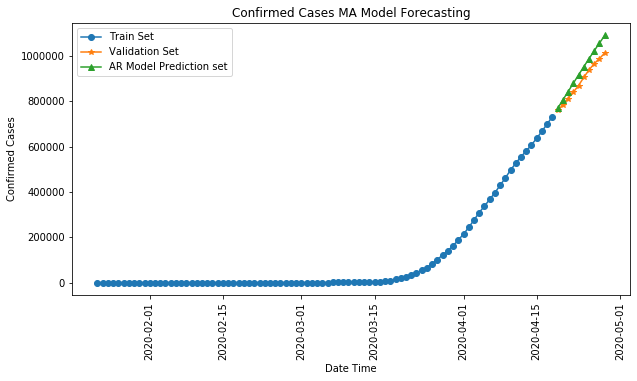

In [157]:
plt.figure(figsize=(10,5))
plt.plot(X_train.index,X_train["Confirmed"],label="Train Set",marker='o')
plt.plot(X_validtesting.index,X_validtesting["Confirmed"],label="Validation Set",marker='*')
plt.plot(X_validtesting.index, pd.Series(list(np.exp(prediction_ma))),label="AR Model Prediction set",marker="^")
plt.legend()
plt.xlabel("Date Time")
plt.ylabel('Confirmed Cases')
plt.title("Confirmed Cases MA Model Forecasting")
plt.xticks(rotation=90)

In [158]:
model_predictions["MA Model Prediction"]=np.array(np.exp(model_ma_fit.forecast(len(X_validtesting)+20)[0][-20:]))

#### Timeseries forecasting using ARIMA

In [159]:

p = d = q = range(1, 4)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (1, 1, 2) x (1, 1, 2, 12)
SARIMAX: (1, 1, 2) x (1, 1, 3, 12)
SARIMAX: (1, 1, 3) x (1, 2, 1, 12)
SARIMAX: (1, 1, 3) x (1, 2, 2, 12)


In [160]:
param=[(3,2,1),(3,2,2),(3,2,3),(3,1,1),(3,1,2),(3,1,3),(3,2,1)]
for each in param:
    mod = ARIMA(log_train,each)
    results = mod.fit()
    print('x{}12 - AIC: {}'.format(each, results.aic))
    


x(3, 2, 1)12 - AIC: -46.5015831727018
x(3, 2, 2)12 - AIC: -50.17654654839302
x(3, 2, 3)12 - AIC: -52.65059628153713
x(3, 1, 1)12 - AIC: -52.27666806886788
x(3, 1, 2)12 - AIC: -53.86688250154219
x(3, 1, 3)12 - AIC: -54.88237773095062
x(3, 2, 1)12 - AIC: -46.5015831727018


##### Traning ARIMA Model on (1,2,1) -> (p.d.q) values

In [161]:
model_arima=ARIMA(log_train,(1,2,1))
model_arima_fit=model_arima.fit()

In [162]:
prediction_arima=model_arima_fit.forecast(len(X_validtesting))[0]
y_pred["ARIMA Model Prediction"]=list(np.exp(prediction_arima))


In [163]:
model_err.update({"ARIMA Model" :np.sqrt(mean_squared_error(list(X_validtesting["Confirmed"]),np.exp(prediction_arima)))})
print("Root Mean Square Error for ARIMA Model: ",np.sqrt(mean_squared_error(list(X_validtesting["Confirmed"]),np.exp(prediction_arima))))

Root Mean Square Error for ARIMA Model:  31572.870901059312


(array([737456., 737470., 737485., 737499., 737516., 737530., 737546.]),
 <a list of 7 Text xticklabel objects>)

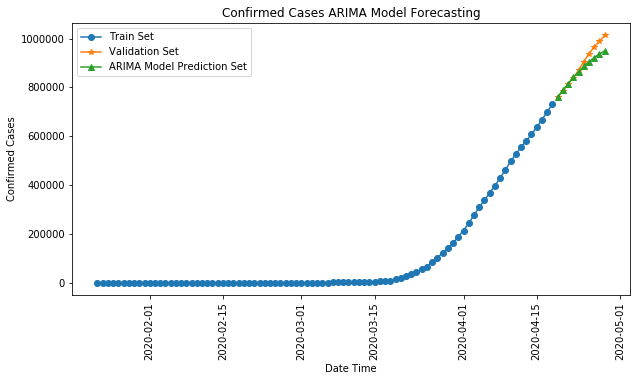

In [164]:
plt.figure(figsize=(10,5))
plt.plot(X_train.index,X_train["Confirmed"],label="Train Set",marker='o')
plt.plot(X_validtesting.index,X_validtesting["Confirmed"],label="Validation Set",marker='*')
plt.plot(X_validtesting.index, pd.Series(np.exp(prediction_arima)),label="ARIMA Model Prediction Set",marker='^')
plt.legend()
plt.xlabel("Date Time")
plt.ylabel('Confirmed Cases')
plt.title("Confirmed Cases ARIMA Model Forecasting")
plt.xticks(rotation=90)

#### Facebook Prophet Model

In [165]:
prophet_c=Prophet(interval_width=0.95,weekly_seasonality=True,)
prophet_confirmed=pd.DataFrame(zip(list(datewise.index),list(X_train["Confirmed"])),columns=['ds','y'])

In [166]:
prophet_c.fit(prophet_confirmed)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [167]:
forecast_c=prophet_c.make_future_dataframe(periods=10)
forecast_confirmed=forecast_c.copy()

Figure(720x432)


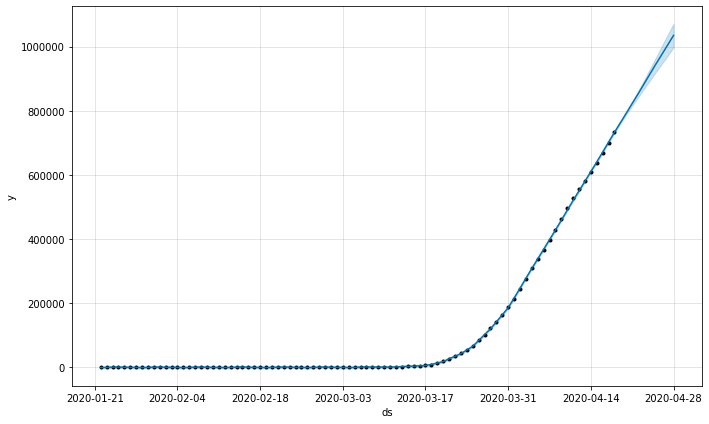

In [169]:
confirmed_forecast=prophet_c.predict(forecast_c)
print(prophet_c.plot(confirmed_forecast))

Figure(648x432)


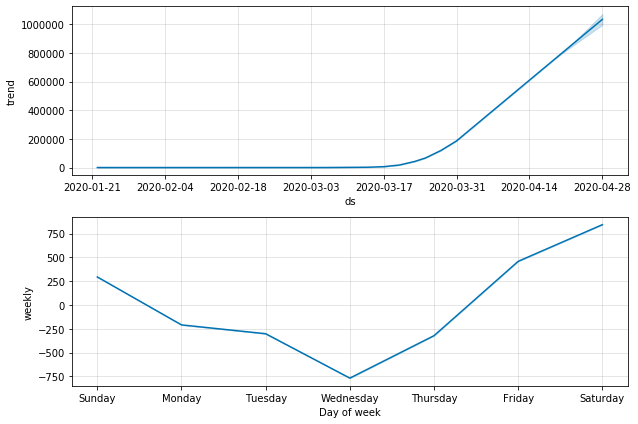

In [171]:
print(prophet_c.plot_components(confirmed_forecast))


In [172]:
X_validtesting.shape

(10, 9)

In [173]:
confirmed_forecast["yhat"][-10:]

88    7.624784e+05
89    7.922921e+05
90    8.225165e+05
91    8.523675e+05
92    8.831307e+05
93    9.142289e+05
94    9.449312e+05
95    9.746993e+05
96    1.004513e+06
97    1.034737e+06
Name: yhat, dtype: float64

In [174]:
model_err.update({"Facebook Prophet" : np.sqrt(mean_squared_error(X_validtesting["Confirmed"],confirmed_forecast['yhat'][-10:]))})
print("Root Mean Squared Error for Prophet Model: ",np.sqrt(mean_squared_error(X_validtesting["Confirmed"],confirmed_forecast['yhat'][-10:])))

Root Mean Squared Error for Prophet Model:  12216.923277446744


### SUMMARY OF PREDICTED MODELS

In [213]:
df = pd.DataFrame(model_err, index=[1])

In [218]:
new_df=pd.DataFrame(df.transpose()).rename(columns={1:"Root Mean Squared Error"})

In [219]:
new_df

,Root Mean Squared Error
Linear Regression,179241.284131
SVM Regressor,76909.092778
Holt's Linear,27297.309505
AR Model,15944.200267
MA Model,48771.355888
ARIMA Model,31572.870901
Facebook Prophet,12216.923277


We can clerly see that Facebook Prophet models fits best with the data and predicted more accurate results than other regression and time series models.